# Influence functions for data mis-labelling

Both data mis-labelling and outlier detection target the same problem, they are operating on discrete and continuous values, respectively. A influence function $I(x_1, x_2) \colon \mathbb{R}^n \times \mathbb{R}^n \to \mathbb{R} $ measures the influence of the data point $x_1$ onto $x_2$ conditioned on the training targets $y_1$ and $y_2$. As long as the loss function $L(x, y)$ is differentiable (or can be approximated by a surrogate objective). Imagine a simple classification problem, where $y_i \in \{1, \dots, K\}$, the goal is now to find labels which are mislabelled. In our case we further simplify the problem to set $K=2$.

## Artificial data generation

First we generate a K-class, M-dimensional dataset using a Gaussian mixture model (GMM). This can be done by sampling $N$ data points from a discrete distribution with $K$ different values. For each of these different discrete states a mean is specified and the observation $x$ is sampled accordingly.

In [ ]:
from valuation.utils import Dataset
from sklearn.model_selection import train_test_split

import numpy as np

N = 1000
K = 2
M = 2
sigma = 0.2

gaussian_mean = np.asarray([
    [0.0, 0.0],
    [1.0, 1.0]
])
gaussian_cov = sigma * np.eye(M)
gaussian_chol = np.linalg.cholesky(gaussian_cov)
y = np.random.randint(K, size=N)
x = np.einsum('ij,kj->ki', gaussian_chol, np.random.normal(size=[N, M])) + gaussian_mean[y]
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.70)
dataset = Dataset(
    x_train,
    y_train,
    x_test,
    y_test
)

## Inspecting the dataset

It is always helpful to visualize the dataset, in the 2-dimensional case it is rather straight forward and we just choose one color for each class. Note that both the train and test set are plotted separately.

In [ ]:
import matplotlib.pyplot as plt

datasets = {
    'train': (dataset.x_train, dataset.y_train),
    'test': (dataset.x_test, dataset.y_test)
}
num_datasets = len(datasets)
fig, ax = plt.subplots(1, num_datasets, figsize=(12, 4))

for i, dataset_name in enumerate(datasets.keys()):
    x, y = datasets[dataset_name]
    ax[i].set_title(dataset_name)

    for v in np.unique(y):
        idx = np.argwhere(y == v)
        ax[i].scatter(x[idx, 0], x[idx, 1], label=str(v))


plt.legend()
plt.show()

As one can see the two classes slighlty overlap and we expect sampples from this region to have higher influence on the remaining region. We are going to verify this in the next section.

## Calculating linear influences using logistic regression

For calculating the influences his section we utilize a logistic regression model to identify wrongly labelled data samples. As a first step one needs to define a model, fit it to the data and then insert it in the influence function

In [ ]:
from valuation.models.pytorch_model import PyTorchSupervisedModel, PyTorchOptimizer
from valuation.influence.general import influences
from valuation.influence.types import InfluenceTypes
from valuation.models.binary_logistic_regression import BinaryLogisticRegressionTorchModel
import torch.nn.functional as F

objective = F.binary_cross_entropy
model = PyTorchSupervisedModel(
    model=BinaryLogisticRegressionTorchModel(M),
    objective=F.binary_cross_entropy,
    num_epochs=1000,
    batch_size=128,
    optimizer=PyTorchOptimizer.ADAM_W,
    optimizer_kwargs={"lr": 0.01, "weight_decay": 0.005},
)
model.fit(
    dataset.x_train,
    dataset.y_train
)

train_influences = influences(
    model,
    dataset.x_train,
    dataset.y_train,
    dataset.x_test,
    dataset.y_test,
    influence_type=InfluenceTypes.Up
)
test_influences = influences(
    model,
    dataset.x_test,
    dataset.y_test,
    influence_type=InfluenceTypes.Up
)

# Plotting the mean influences of the training samples

Next we are going to calculate the mean absolute influences of the training samples and plot them.

In [ ]:
mean_influences = lambda arr: np.mean(np.abs(arr), axis=0)
mean_train_influences = mean_influences(train_influences)
mean_test_influences = mean_influences(test_influences)

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()

fig, ax = plt.subplots(1, num_datasets, figsize=(12, 4))
mean_influences = {
    'train': mean_train_influences,
    'test': mean_test_influences
}
v_max = max(np.max(mean_train_influences), np.max(mean_test_influences))
for i, dataset_name in enumerate(datasets.keys()):
    x = datasets[dataset_name][0].copy()
    ax[i].set_title(dataset_name)
    points = ax[i].scatter(x[:, 0], x[:, 1], c=mean_influences[dataset_name], vmin=0, vmax=v_max, cmap="plasma")

plt.suptitle("Influences of training and test set.")
plt.colorbar(points)
plt.show()

## Flipping 5% of the labels of the train set

We assume that our reference test set is not flipped and was checked, e.g. by human inspection. In comparison the test set gets flipped 5% at random positions. We want to show how to identify flipped examples 

In [ ]:
flip_percentage = 0.05
flip_num_samples = int(flip_percentage * len(dataset.x_train))
idx = np.random.choice(len(dataset.x_train), replace=False, size=flip_num_samples)

In [ ]:
flipped_dataset = Dataset(
    dataset.x_train.copy(),
    dataset.y_train.copy(),
    dataset.x_test.copy(),
    dataset.y_test.copy()
)
flipped_dataset.y_train[idx] = 1 - flipped_dataset.y_train[idx]

## Identifiying data points with absurd high gradients

In [ ]:
flipped_train_test_influences = influences(
    model,
    flipped_dataset.x_train,
    flipped_dataset.y_train,
    flipped_dataset.x_test,
    flipped_dataset.y_test,
    influence_type=InfluenceTypes.Up
)

In [ ]:
mean_flipped_train_test_influences = np.abs(np.mean(flipped_train_test_influences, axis=0))
estimated_idx = np.flip(np.argsort(mean_flipped_train_test_influences))[:len(idx)]

In [ ]:
found_elements = set(estimated_idx).intersection(set(idx))
remaining_element = set(idx).difference(set(estimated_idx))
display(f"Around {100* len(found_elements) / len(idx):.2f} could be identified. But there are {100* len(remaining_element) / len(idx):.2f}% remaining samples")

As we can see it was very straightforward to identify 82% of the 5% flipped data samples. This accounts for at most 1% remaining flipped samples. We now want to take a look at these cases.

In [ ]:
import matplotlib.pyplot as plt

remaining_idx = np.asarray(list(remaining_element), dtype=int)
plt.figure()
y = flipped_dataset.y_train[remaining_idx]
for v in np.unique(y):
    sub_idx = np.argwhere(y == v)
    c_idx = remaining_idx[sub_idx]
    plt.scatter(flipped_dataset.x_train[c_idx, 0], flipped_dataset.x_train[c_idx, 1], label=str(v))

plt.legend()
plt.show()

In [91]:
mean_flipped_train_test_influences = np.abs(np.mean(flipped_train_test_influences, axis=0))
estimated_idx = np.flip(np.argsort(mean_flipped_train_test_influences))[:len(idx)]

In [103]:
found_elements = set(estimated_idx).intersection(set(idx))
remaining_element = set(idx).difference(set(estimated_idx))
display(f"Around {100* len(found_elements) / len(idx):.2f} could be identified. But there are {100* len(remaining_element) / len(idx):.2f}% remaining samples")

'Around 82.86 could be identified. But there are 17.14% remaining elements'

As we can see it was very straightforward to identify 82% of the 5% flipped data samples. This accounts for at most 1% remaining flipped samples. We now want to take a look at these cases.

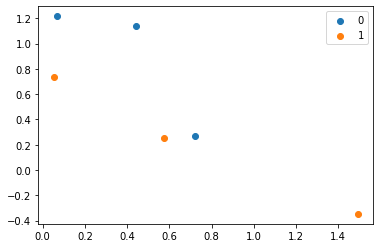

In [115]:
import matplotlib.pyplot as plt

remaining_idx = np.asarray(list(remaining_element), dtype=int)
plt.figure()
y = flipped_dataset.y_train[remaining_idx]
for v in np.unique(y):
    sub_idx = np.argwhere(y == v)
    c_idx = remaining_idx[sub_idx]
    plt.scatter(flipped_dataset.x_train[c_idx, 0], flipped_dataset.x_train[c_idx, 1], label=str(v))

plt.legend()
plt.show()